In [1]:
# importing the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet,DenseNet121
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from glob import glob
import pandas as pd
from tqdm import tqdm

In [2]:
#defining the paths
train_path = r'C:\Users\Raghav\Downloads\data\train'
test_path= r'C:\Users\Raghav\Downloads\data\test'

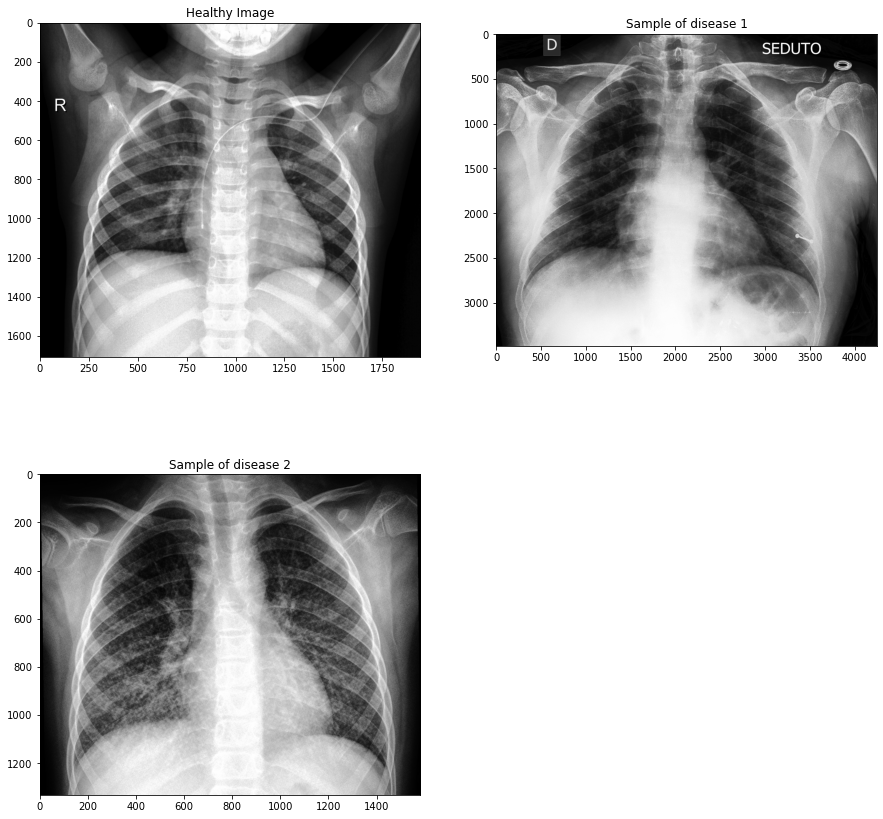

In [3]:
#Displaying sample images
plt.figure(figsize=(15,15))
img1= cv2.imread(r'C:\Users\Raghav\Downloads\data\train\Type 1 disease\01.jpeg')
img2= cv2.imread(r'C:\Users\Raghav\Downloads\data\train\Type 2 disease\01.jpeg')
img3= cv2.imread(r'C:\Users\Raghav\Downloads\data\train\healthy\01.jpeg')
plt.subplot(2,2,1)
plt.imshow(img3)
plt.title('Healthy Image')

plt.subplot(2,2,2)
plt.imshow(img1)
plt.title('Sample of disease 1')


plt.subplot(2,2,3)
plt.imshow(img2)
plt.title('Sample of disease 2')
plt.show()

In [4]:
class_names = ['healthy','Type 1 disease', 'Type 2 disease']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [5]:
#dataloader
def load_data():
    
    datasets = [train_path,test_path]
    output = []
    
    # Iterating through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
       
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                labels.append(label)
                
        images = np.array(images)
        labels = np.array(labels)   
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  0%|                                                                                           | 0/70 [00:00<?, ?it/s]

Loading C:\Users\Raghav\Downloads\data\train


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 59.10it/s]
<ipython-input-5-c8dd078bf2cc>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)
 15%|████████████▍                                                                      | 3/20 [00:00<00:00, 29.37it/s]

Loading C:\Users\Raghav\Downloads\data\test


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.88it/s]


In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))

Number of training examples: 251
Number of testing examples: 66


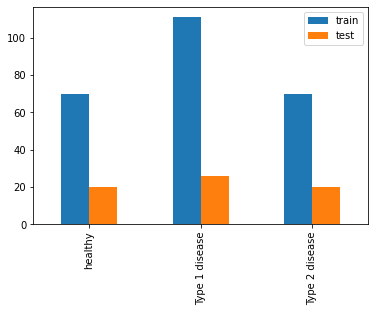

In [8]:
#visualising data
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
            'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

In [9]:
#augmentations
train_datagen = ImageDataGenerator(rescale=1.//255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip = True,
                                   vertical_flip= True)
training_set = train_datagen.flow_from_directory( r'C:\Users\Raghav\Downloads\data\train',
                                                 target_size = (224,224),#will be changed to (224,224) for densenet and mobilenet
                                                 class_mode = 'categorical')

Found 251 images belonging to 3 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1.//255,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip = True,
                                 vertical_flip= True)
test_set = test_datagen.flow_from_directory( r'C:\Users\Raghav\Downloads\data\test',
                                           target_size=(224,224),#will be changed to (224,224) for densenet and mobilenet
                                           class_mode='categorical')

Found 66 images belonging to 3 classes.


In [86]:
#defining model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (48,48, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = (48,48, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(axis=1,momentum=0.99),
    tf.keras.layers.Dropout(0.25, seed=123),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [87]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 64)        

In [88]:
model.compile(optimizer = 'RMSprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)

In [90]:
history = model.fit(training_set, batch_size=25, callbacks=[early_stopping], epochs=10, steps_per_epoch=len(training_set))

Epoch 1/10
8/8 [==============================] - 9s 1s/step - loss: 2.9403 - accuracy: 0.2988
Epoch 2/10
8/8 [==============================] - 8s 954ms/step - loss: 1.1141 - accuracy: 0.4143
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 1.1450 - accuracy: 0.4303
Epoch 4/10
8/8 [==============================] - 8s 990ms/step - loss: 1.1783 - accuracy: 0.4343
Epoch 5/10
8/8 [==============================] - 8s 1s/step - loss: 1.0480 - accuracy: 0.4821
Epoch 6/10
8/8 [==============================] - 8s 992ms/step - loss: 0.9399 - accuracy: 0.5777
Epoch 7/10
8/8 [==============================] - 8s 975ms/step - loss: 0.9746 - accuracy: 0.6016
Epoch 8/10
8/8 [==============================] - 8s 1s/step - loss: 0.7532 - accuracy: 0.6574
Epoch 9/10
8/8 [==============================] - 8s 900ms/step - loss: 0.7968 - accuracy: 0.6255
Epoch 10/10
8/8 [==============================] - 8s 974ms/step - loss: 0.6280 - accuracy: 0.7291


KeyError: 'val_loss'

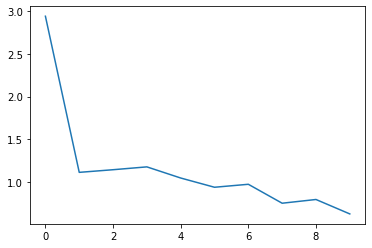

In [91]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.show()

KeyError: 'val_accuracy'

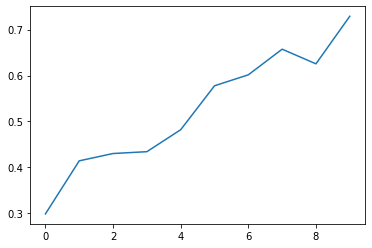

In [92]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.show()

In [93]:
y_true = test_set.labels
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_set.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels="confusion matrix")
print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.31      0.38        26
           1       1.00      0.05      0.10        20
           2       0.39      0.95      0.55        20

    accuracy                           0.42        66
   macro avg       0.63      0.44      0.34        66
weighted avg       0.62      0.42      0.35        66



In [94]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average=None)

array([0.38095238, 0.0952381 , 0.55072464])

## MOBILENET IMPLEMENTATION

In [30]:
#importing base model as MobileNet
baseModel = MobileNet( include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [31]:
headModel = baseModel.output
headModel = BatchNormalization(axis=1,momentum=0.90)(headModel)
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
modelmobilenet = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
opt = tf.keras.optimizers.RMSprop()
modelmobilenet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [32]:
historymobilenet = modelmobilenet.fit(training_set,
                                      batch_size=25,
                                      callbacks=[early_stopping],
                                      epochs=10,
                                      steps_per_epoch=len(training_set))

Epoch 1/10
8/8 [==============================] - 14s 2s/step - loss: 1.3183 - accuracy: 0.4622
Epoch 2/10
8/8 [==============================] - 12s 1s/step - loss: 0.8210 - accuracy: 0.6175
Epoch 3/10
8/8 [==============================] - 12s 2s/step - loss: 0.7935 - accuracy: 0.6335
Epoch 4/10
8/8 [==============================] - 12s 2s/step - loss: 0.6901 - accuracy: 0.6972
Epoch 5/10
8/8 [==============================] - 12s 2s/step - loss: 0.6668 - accuracy: 0.7131
Epoch 6/10
8/8 [==============================] - 12s 2s/step - loss: 0.6205 - accuracy: 0.7450
Epoch 7/10
8/8 [==============================] - 13s 2s/step - loss: 0.5927 - accuracy: 0.7490
Epoch 8/10
8/8 [==============================] - 13s 2s/step - loss: 0.5934 - accuracy: 0.7769
Epoch 9/10
8/8 [==============================] - 13s 2s/step - loss: 0.5947 - accuracy: 0.7689
Epoch 10/10
8/8 [==============================] - 13s 2s/step - loss: 0.5312 - accuracy: 0.7649


KeyError: 'val_loss'

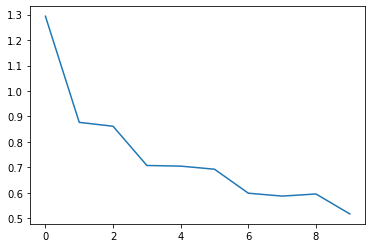

In [25]:
plt.figure()
plt.plot(historymobilenet.history["loss"], label="train_loss")
plt.plot(historymobilenet.history["val_loss"], label="val_loss")
plt.show()

KeyError: 'val_accuracy'

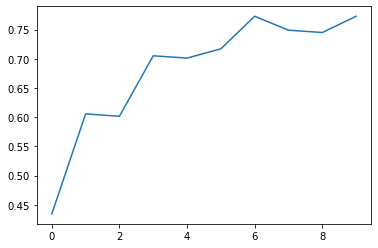

In [26]:
plt.plot(historymobilenet.history["accuracy"], label="train_acc")
plt.plot(historymobilenet.history["val_accuracy"], label="val_acc")
plt.show()

In [27]:
y_true = test_set.labels
Y_predm = modelmobilenet.predict(test_set)
y_predm = np.argmax(Y_predm, axis=1)
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_set.classes, y_predm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels="confusion matrix")
print(classification_report(test_set.classes, y_predm))

              precision    recall  f1-score   support

           0       0.36      0.38      0.37        26
           1       0.26      0.35      0.30        20
           2       0.27      0.15      0.19        20

    accuracy                           0.30        66
   macro avg       0.30      0.29      0.29        66
weighted avg       0.30      0.30      0.29        66



# DENSENET IMPLEMENTATION

In [11]:
#importing base model as MobileNet
baseModel1 = DenseNet121( include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [1]:
headModel = baseModel1.output
headModel = BatchNormalization(axis=1,momentum=0.90)(headModel)
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
modeldensenet = Model(inputs=baseModel1.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel1.layers:
    layer.trainable = False

# compile our model
opt = tf.keras.optimizers.Adam()
modeldensenet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

NameError: name 'baseModel1' is not defined

In [18]:
historydenseenet = modeldensenet.fit(training_set,
                                      batch_size=10,
                                      callbacks=[early_stopping],
                                      epochs=20,
                                      steps_per_epoch=len(training_set))

Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 0.5855 - accuracy: 0.7610
Epoch 2/20
8/8 [==============================] - 20s 2s/step - loss: 0.5239 - accuracy: 0.7849
Epoch 3/20
8/8 [==============================] - 20s 2s/step - loss: 0.5234 - accuracy: 0.8167
Epoch 4/20
8/8 [==============================] - 20s 2s/step - loss: 0.6376 - accuracy: 0.7371
Epoch 5/20
8/8 [==============================] - 20s 2s/step - loss: 0.5089 - accuracy: 0.8088
Epoch 6/20
8/8 [==============================] - 20s 2s/step - loss: 0.4329 - accuracy: 0.8327
Epoch 7/20
8/8 [==============================] - 20s 2s/step - loss: 0.5174 - accuracy: 0.7649
Epoch 8/20
8/8 [==============================] - 20s 2s/step - loss: 0.5038 - accuracy: 0.7928
Epoch 9/20
8/8 [==============================] - 20s 3s/step - loss: 0.4538 - accuracy: 0.8127
Epoch 10/20
8/8 [==============================] - 20s 2s/step - loss: 0.4423 - accuracy: 0.8167
Epoch 11/20
8/8 [======================

KeyError: 'val_loss'

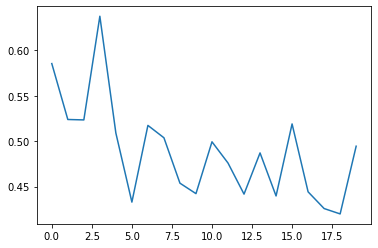

In [19]:
plt.figure()
plt.plot(historydenseenet.history["loss"], label="train_loss")
plt.plot(historydenseenet.history["val_loss"], label="val_loss")
plt.show()

KeyError: 'val_accuracy'

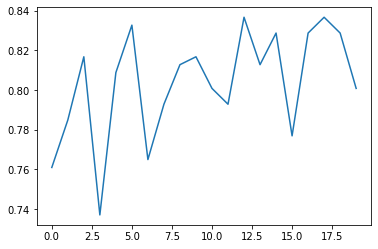

In [20]:
plt.plot(historydenseenet.history["accuracy"], label="train_acc")
plt.plot(historydenseenet.history["val_accuracy"], label="val_acc")
plt.show()

In [21]:
y_true = test_set.labels
Y_predd = modeldensenet.predict(test_set)
y_predd = np.argmax(Y_predd, axis=1)
from sklearn.metrics import ConfusionMatrixDisplay
print(classification_report(test_set.classes, y_predd))

              precision    recall  f1-score   support

           0       0.46      0.50      0.48        26
           1       0.38      0.30      0.33        20
           2       0.36      0.40      0.38        20

    accuracy                           0.41        66
   macro avg       0.40      0.40      0.40        66
weighted avg       0.41      0.41      0.41        66



In [28]:
arr_f1=np.array([[.38,.10,0.55],[0.37,0.30,0.19],[0.48,0.33,0.38]])

In [29]:
arr_f1

array([[0.38, 0.1 , 0.55],
       [0.37, 0.3 , 0.19],
       [0.48, 0.33, 0.38]])

# Conclusion
 
The data seems insufficient for a model to train on, as the f1_scores are pretty abysmal for all the models.